<a href="https://colab.research.google.com/github/El-amin/CNN-Based-Plant-Disease-Detection-Model/blob/main/Msoc_Paper_extension_with_knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation

**Author:** [Aminu Musa]
**Date created:** 2022/09/01<br>
**Last modified:** 2020/09/01<br>
**Description:** Plant disease detection With Knowledge Distillation Technique.

In [ ]:
import os
import pickle
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer


## Construct `Distiller()` class

The custom `Distiller()` class, overrides the `Model` methods `train_step`, `test_step`,
and `compile()`. In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `train_step` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha` and
`1 - alpha`, respectively, and perform the backward pass. Note: only the student weights are updated,
and therefore we only calculate the gradients for the student weights.

In the `test_step` method, we evaluate the student model on the provided dataset.

In [ ]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir 'Road_dataset'

In [ ]:
local_zip = '/content/drive/MyDrive/Msoc/PlantVillage.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/Road_dataset')
zip_ref.close()


In [ ]:
TRAINING_DIR = "/msoc/PlantVillage/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255
                
               )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=250,
                                                    target_size=(250, 250))

VALIDATION_DIR = "/msoc/PlantVillage/val/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              batch_size=250,
                                                              target_size=(250, 250))

Found 44016 images belonging to 39 classes.
Found 11004 images belonging to 39 classes.


In [ ]:
train_y=train_generator.classes


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(train_y)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

## Create student and teacher models

Initialy, we create a teacher model and a smaller student model. Both models are
convolutional neural networks and created using `Sequential()`,
but could be any Keras model.

In [ ]:
# Create the teacher
teacher = keras.Sequential(name="teacher",)
inputShape = (250, 250, 3)
chanDim = -1
if K.image_data_format() == "channels_first":
           inputShape = (3, 250, 250)
           chanDim = 1
teacher.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization(axis=chanDim))
teacher.add(MaxPooling2D(pool_size=(3, 3)))
teacher.add(Dropout(0.25))
teacher.add(Conv2D(64, (3, 3), padding="same"))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization(axis=chanDim))
teacher.add(Conv2D(64, (3, 3), padding="same"))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization(axis=chanDim))
teacher.add(MaxPooling2D(pool_size=(2, 2)))
teacher.add(Dropout(0.25))
teacher.add(Conv2D(128, (3, 3), padding="same"))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization(axis=chanDim))
teacher.add(Conv2D(128, (3, 3), padding="same"))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization(axis=chanDim))
teacher.add(MaxPooling2D(pool_size=(2, 2)))
teacher.add(Dropout(0.25))
teacher.add(Flatten())
teacher.add(Dense(1024))
teacher.add(Activation("relu"))
teacher.add(BatchNormalization())
teacher.add(Dropout(0.5))
teacher.add(Dense(n_classes))


# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(250, 250, 3)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(n_classes),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

In [ ]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 83, 83, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 83, 83, 64)        1849

In [ ]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 250, 250, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 250, 250, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 83, 83, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 83, 83, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 83, 83, 64)        1849

In [ ]:
print(os.listdir('/msoc/PlantVillage/train'))

['Tomato___healthy', 'Tomato___Early_blight', 'background', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Apple___Black_rot', 'Potato___Late_blight', 'Blueberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Peach___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Apple___Apple_scab', 'Tomato___Leaf_Mold', 'Apple___healthy', 'Cherry_(including_sour)___healthy', 'Tomato___Target_Spot', 'Cherry_(including_sour)___Powdery_mildew', 'Soybean___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Apple___Cedar_apple_rust', 'Pepper,_bell___healthy', 'Grape___Black_rot', 'Tomato___Bacterial_spot', 'Potato___Early_blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Late_blight', 'Potato___healthy', 'Tomato___Septoria_leaf_spot', 'Peach___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Squash___Powdery_mil

## Train the teacher

In knowledge distillation we assume that the teacher is trained and fixed. Thus, we start
by training the teacher model on the training set in the usual way.

In [ ]:
# Train teacher as usual
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)


In [ ]:
teacher_history=teacher.fit(train_generator,steps_per_epoch=176,
            validation_data=validation_generator,
             epochs=10, validation_steps=44)


Epoch 1/10
176/176 [==============================] - 287s 2s/step - loss: 0.7934 - acc: 0.7780 - val_loss: 11.1354 - val_acc: 0.0393
Epoch 2/10
176/176 [==============================] - 254s 1s/step - loss: 0.2772 - acc: 0.9136 - val_loss: 10.4615 - val_acc: 0.0815
Epoch 3/10
176/176 [==============================] - 256s 1s/step - loss: 0.1565 - acc: 0.9522 - val_loss: 4.0241 - val_acc: 0.3545
Epoch 4/10
176/176 [==============================] - 267s 2s/step - loss: 0.0926 - acc: 0.9711 - val_loss: 1.0349 - val_acc: 0.7830
Epoch 5/10
176/176 [==============================] - 256s 1s/step - loss: 0.0720 - acc: 0.9773 - val_loss: 0.3277 - val_acc: 0.9005
Epoch 6/10
176/176 [==============================] - 267s 2s/step - loss: 0.0450 - acc: 0.9859 - val_loss: 2.5274 - val_acc: 0.6583
Epoch 7/10
176/176 [==============================] - 256s 1s/step - loss: 0.0615 - acc: 0.9806 - val_loss: 0.2300 - val_acc: 0.9326
Epoch 8/10
176/176 [==============================] - 256s 1s/step 

range(1, 6)


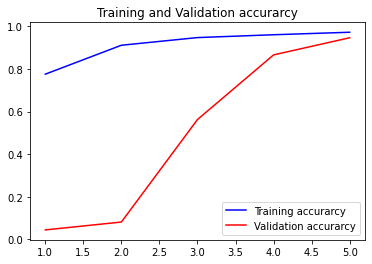

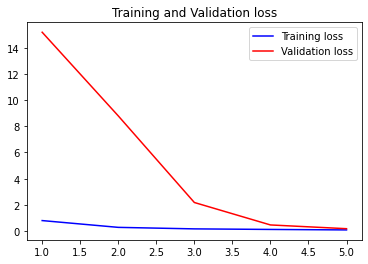

In [ ]:
import matplotlib.pyplot as plt
acc = teacher_history.history['acc']
val_acc = teacher_history.history['val_acc']
loss = teacher_history.history['loss']
val_loss = teacher_history.history['val_loss']
print(range(1, len(acc) + 1))

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()



plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
import pickle 
print("[INFO] Saving model...")
pickle.dump(teacher,open('/content/drive/MyDrive/Msoc/Teacher_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://0da4707f-c5df-4bda-b7ed-70e59d29e222/assets


In [ ]:
teacher.save('/content/drive/MyDrive/Msoc/Teacher_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Msoc/Teacher_model/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Msoc/Teacher_model') # path to the SavedModel directory
Teacher_tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Msoc/model.tflite', 'wb') as f:
  f.write(Teacher_tflite_model)

In [ ]:
import numpy as np

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(output_details)
# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[{'name': 'StatefulPartitionedCall:0', 'index': 46, 'shape': array([ 1, 39], dtype=int32), 'shape_signature': array([-1, 39], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[  2.0873563   -2.7428818    3.434671    -2.6104627   -1.9398451
   -1.1396211    0.5834581    9.265304    -1.7548139    8.542576
   13.819666    -6.457953    -0.35535896  -0.49823394   2.221366
   -7.88183      2.7577302   -0.47831208 -13.813183    -2.3824034
   -0.40080208  -4.3179355   -4.1108446   -1.1667194   15.367432
    8.119192    -3.5071356   -0.1374922    4.443355    -4.50748
    3.7178106   -2.9736228  -10.0996685   -0.805652    -4.5626903
   -4.098029    -3.1691206   15.816592     2.1183858 ]]


## Distill teacher to student

We have already trained the teacher model, and we only need to initialize a
`Distiller(student, teacher)` instance, `compile()` it with the desired losses,
hyperparameters and optimizer, and distill the teacher to the student.

In [ ]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['acc'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
student_history=distiller.fit(train_generator, epochs=1, validation_data=validation_generator)

# Evaluate student on test dataset
#std_history=distiller.evaluate(validation_generator)

177/177 [==============================] - 164s 912ms/step - acc: 0.6089 - student_loss: 1.5783 - distillation_loss: 0.0984 - val_acc: 0.7459 - val_student_loss: 2.2458


range(1, 5)


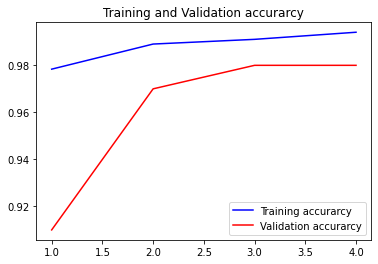

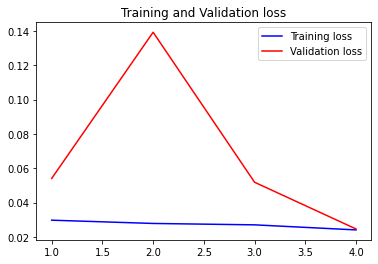

In [ ]:
import matplotlib.pyplot as plt
acc = student_history.history['acc']
val_acc = [0.91,0.97, 0.98, 0.98]
loss = student_history.history['distillation_loss']
val_loss = student_history.history['student_loss']
print(range(1, len(acc) + 1))

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()



plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
import pickle 
print("[INFO] Saving model...")
pickle.dump(distiller,open('Student.pkl', 'wb'))

[INFO] Saving model...


ValueError: ignored

## Train student from scratch for comparison

We can also train an equivalent student model from scratch without the teacher, in order
to evaluate the performance gain obtained by knowledge distillation.

In [ ]:
# Train student as doen usually
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'],
)

# Train and evaluate student trained from scratch.
student_scratch.fit(train_generator, epochs=1)
std_history=student_scratch.evaluate(validation_generator)

45/45 [==============================] - 27s 595ms/step - loss: 0.5070 - acc: 0.8442


In [ ]:
# save the model to disk
import pickle 
print("[INFO] Saving model...")
pickle.dump(student_scratch,open('Student_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://d2b76bb3-cfb1-4a0d-8b63-3493b6211b5b/assets


In [ ]:
/content/Teacher.pkl

If the teacher is trained for 5 full epochs and the student is distilled on this teacher
for 3 full epochs, you should in this example experience a performance boost compared to
training the same student model from scratch, and even compared to the teacher itself.
You should expect the teacher to have accuracy around 97.6%, the student trained from
scratch should be around 97.6%, and the distilled student should be around 98.1%. Remove
or try out different seeds to use different weight initializations.